In [65]:
import fluxy as fl
from influxdb_client.client.influxdb_client_async import InfluxDBClientAsync
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta
import pandas as pd 
import seaborn as sns 
import matplotlib.dates as mdates
import matplotlib.pylab as plt 

load_dotenv()

API_TOKEN = os.getenv("ENERGY_REPORT_API_TOKEN")

In [66]:
start = datetime.now(timezone.utc) - timedelta(days=14)
stop = datetime.now(timezone.utc)
window_size = timedelta(minutes=10)

In [67]:
from pandas import DataFrame


async def submit_query(fl) -> DataFrame:
  async with InfluxDBClientAsync("https://influxdb.prod.power-hub.foundationzero.org", API_TOKEN, "power_hub") as client:
    
    return await client.query_api().query_data_frame(fl.to_flux())
  
from typing import Any

async def get_data(
    sensors_to_query: list[Any],
    query_range: tuple[datetime, datetime],
    resolution: timedelta,
    windowoperation: fl.WindowOperation,
) -> pd.DataFrame:

    query = fl.pipe(
        fl.from_bucket("power_hub"),
        fl.range(*query_range),
        fl.filter(fl.any(fl.conform, sensors_to_query)),
        fl.aggregate_window(resolution, windowoperation, False),
        fl.keep(["_time", "_value", "_field"]),
        fl.pivot(["_time"], ["_field"], "_value"),
    )
    
    df = await submit_query(query)

    return df.drop(columns = ["result","table"]).set_index("_time",drop = True).sort_index()

In [68]:
sns.set_style("whitegrid")

def plot_hourly_avg(data: pd.DataFrame, ylabel: str):
    hourly = data.set_index(data.index.hour)
    hourly = hourly.stack().to_frame(name = ylabel).reset_index(names = ['hour', 'group'])

    fig, ax = plt.subplots(dpi = 300)
    ax = sns.lineplot(data = hourly, x = 'hour', y= ylabel, hue = 'group', palette = 'Paired', dashes = False, linewidth = 2.0, ax = ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Hourly averages from {data.index[0].date()} to {data.index[-1].date()}')

def plot_daily_bars(data: pd.DataFrame, ylabel: str):

    daily = data.resample('h').mean().resample('d').sum() 
    daily_long = daily.stack().reset_index().rename(columns = {'level_1':'group', 0: ylabel})
    
    fig, ax = plt.subplots(dpi = 300)
    ax = sns.barplot(daily_long, x = daily_long['_time'].apply(lambda x: x.date()), hue = 'group', y = daily_long[ylabel], ax = ax)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gcf().autofmt_xdate()
    plt.title('Daily totals')

In [69]:
# Report of the Power Hub performance over the last week

In [70]:


thermal_variables = [
    "heat_pipes_power",
    "cold_reservoir_cooling_demand",
    "cold_reservoir_cooling_supply",
    "yazaki_chill_power",
    "chiller_chill_power",
]

water_variables = [
    "water_maker_production_flow",
    "fresh_to_kitchen_flow_sensor_total_volume",
    "technical_to_wash_off_flow_sensor_total_volume",
    "technical_to_sanitary_flow_sensor_total_volume"
]

battery_levels = ["electrical_battery_system_soc", "pcm_state_of_charge"]



## Electric

In [71]:
from itertools import product

shore_power = [f"electrical_vebus_e{phase}_input_power" for phase in range(1,4)]
compound_power = [f'electrical_e{container}_power_{phase}' for container,phase in product(range(1,9),["L1","L2","L3"])]
hub_power = [f'electrical_thermo_cabinet_power_{phase}' for phase in ["L1","L2","L3"]]

electric_variables = [
    "electrical_pv_power",
    *shore_power,
    *compound_power,
    *hub_power,
    "electrical_battery_system_soc"
]

In [72]:
electric_data = await get_data([{"_field": variable} for variable in electric_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN)
electric_data.index = electric_data.index.tz_convert('Europe/Madrid')

kwh_electric = (electric_data / 1000).resample('h').mean()

In [73]:
from itertools import product

electrical_groups = {
    "pv_power": ["electrical_pv_power"],
    "shore_power": [
        "electrical_vebus_e1_input_power",
        "electrical_vebus_e2_input_power",
        "electrical_vebus_e3_input_power",
    ],
    "consumption_power": [
        "electrical_e1_power_L1",
        "electrical_e1_power_L2",
        "electrical_e1_power_L3",
        "electrical_e2_power_L1",
        "electrical_e2_power_L2",
        "electrical_e2_power_L3",
        "electrical_e3_power_L1",
        "electrical_e3_power_L2",
        "electrical_e3_power_L3",
        "electrical_e4_power_L1",
        "electrical_e4_power_L2",
        "electrical_e4_power_L3",
        "electrical_e5_power_L1",
        "electrical_e5_power_L2",
        "electrical_e5_power_L3",
        "electrical_e6_power_L1",
        "electrical_e6_power_L2",
        "electrical_e6_power_L3",
        "electrical_e7_power_L1",
        "electrical_e7_power_L2",
        "electrical_e7_power_L3",
        "electrical_e8_power_L1",
        "electrical_e8_power_L2",
        "electrical_e8_power_L3",
        "electrical_thermo_cabinet_power_L1",
        "electrical_thermo_cabinet_power_L2",
        "electrical_thermo_cabinet_power_L3",
    ],
}

electrical_consumption_groups = {
    "office": [
        "electrical_e1_power_L1",
        "electrical_e1_power_L2",
        "electrical_e1_power_L3",
    ],
    "workshop": [
        "electrical_e2_power_L1",
        "electrical_e2_power_L2",
        "electrical_e2_power_L3",
    ],
    "simulator": [
        "electrical_e3_power_L1",
        "electrical_e3_power_L2",
        "electrical_e3_power_L3",
    ],
    "kitchen_sanitary_1": [
        "electrical_e4_power_L1",
        "electrical_e4_power_L2",
        "electrical_e4_power_L3",
    ],
    "kitchen_sanitary_2": [
        "electrical_e5_power_L1",
        "electrical_e5_power_L2",
        "electrical_e5_power_L3",
    ],
    "supply_box": [
        "electrical_e6_power_L1",
        "electrical_e6_power_L2",
        "electrical_e6_power_L3",
    ],
    "center_1": [
        "electrical_e7_power_L1",
        "electrical_e7_power_L2",
        "electrical_e7_power_L3",
    ],
    "center_2": [
        "electrical_e8_power_L1",
        "electrical_e8_power_L2",
        "electrical_e8_power_L3",
    ],
    "power_hub": [
        "electrical_thermo_cabinet_power_L1",
        "electrical_thermo_cabinet_power_L2",
        "electrical_thermo_cabinet_power_L3",
    ],
}

electrical_groups_dict_inv = {
    i: k for k in electrical_groups for i in electrical_groups[k]
}

electrical_consumption_groups_dict_inv = {
    i: k for k in electrical_consumption_groups for i in electrical_consumption_groups[k]
}


In [74]:
### Aggregate electric consumption and production

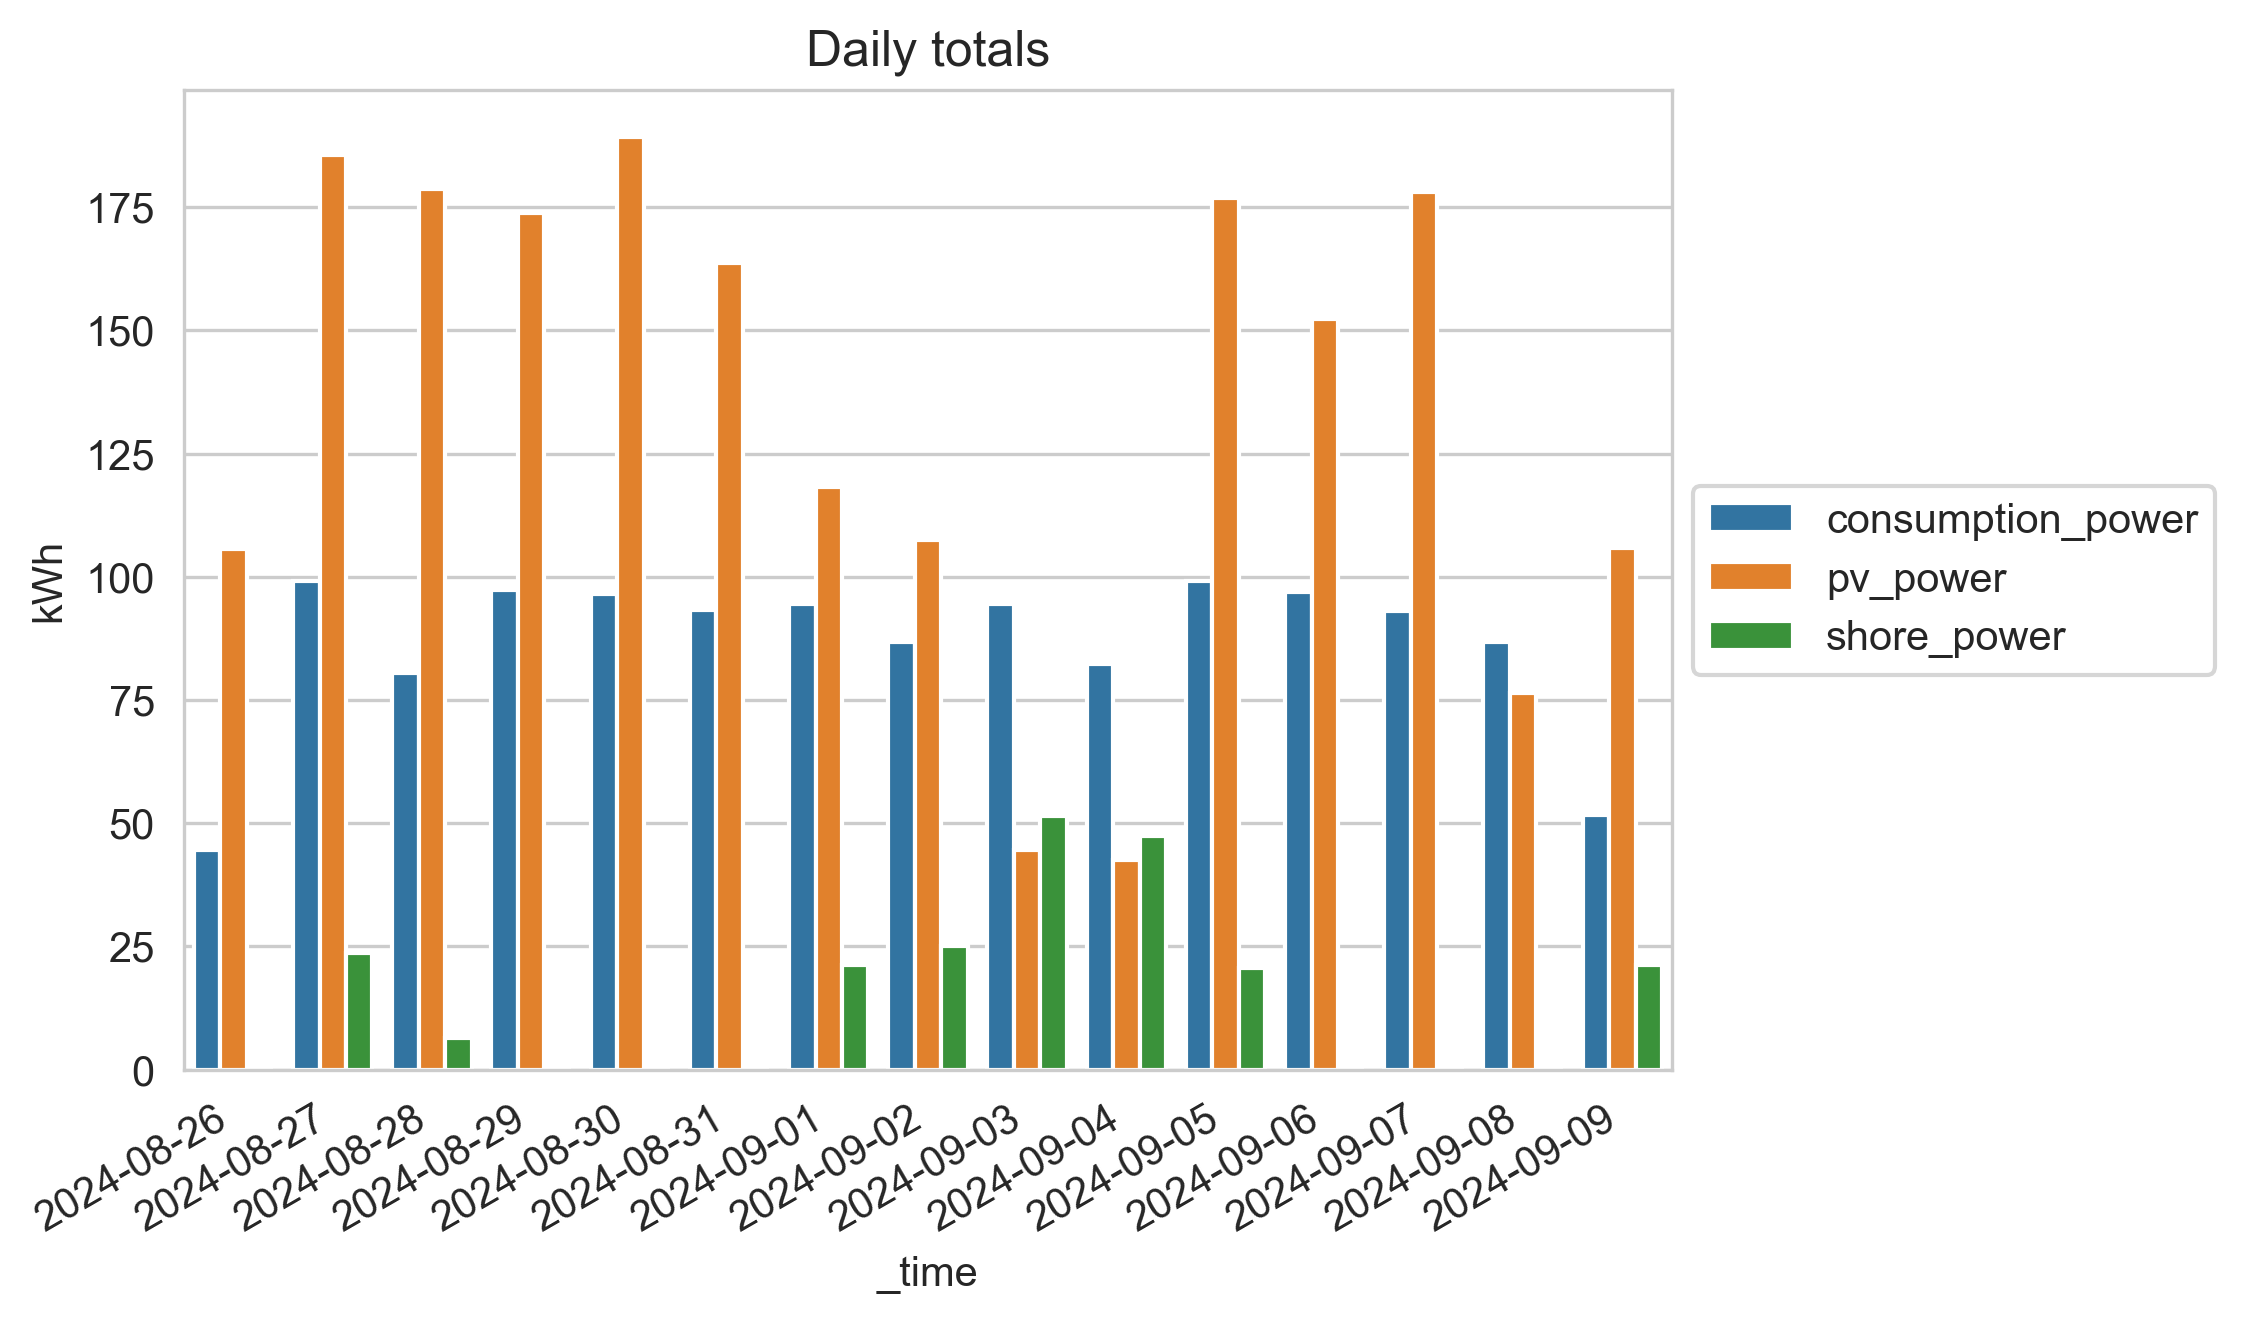

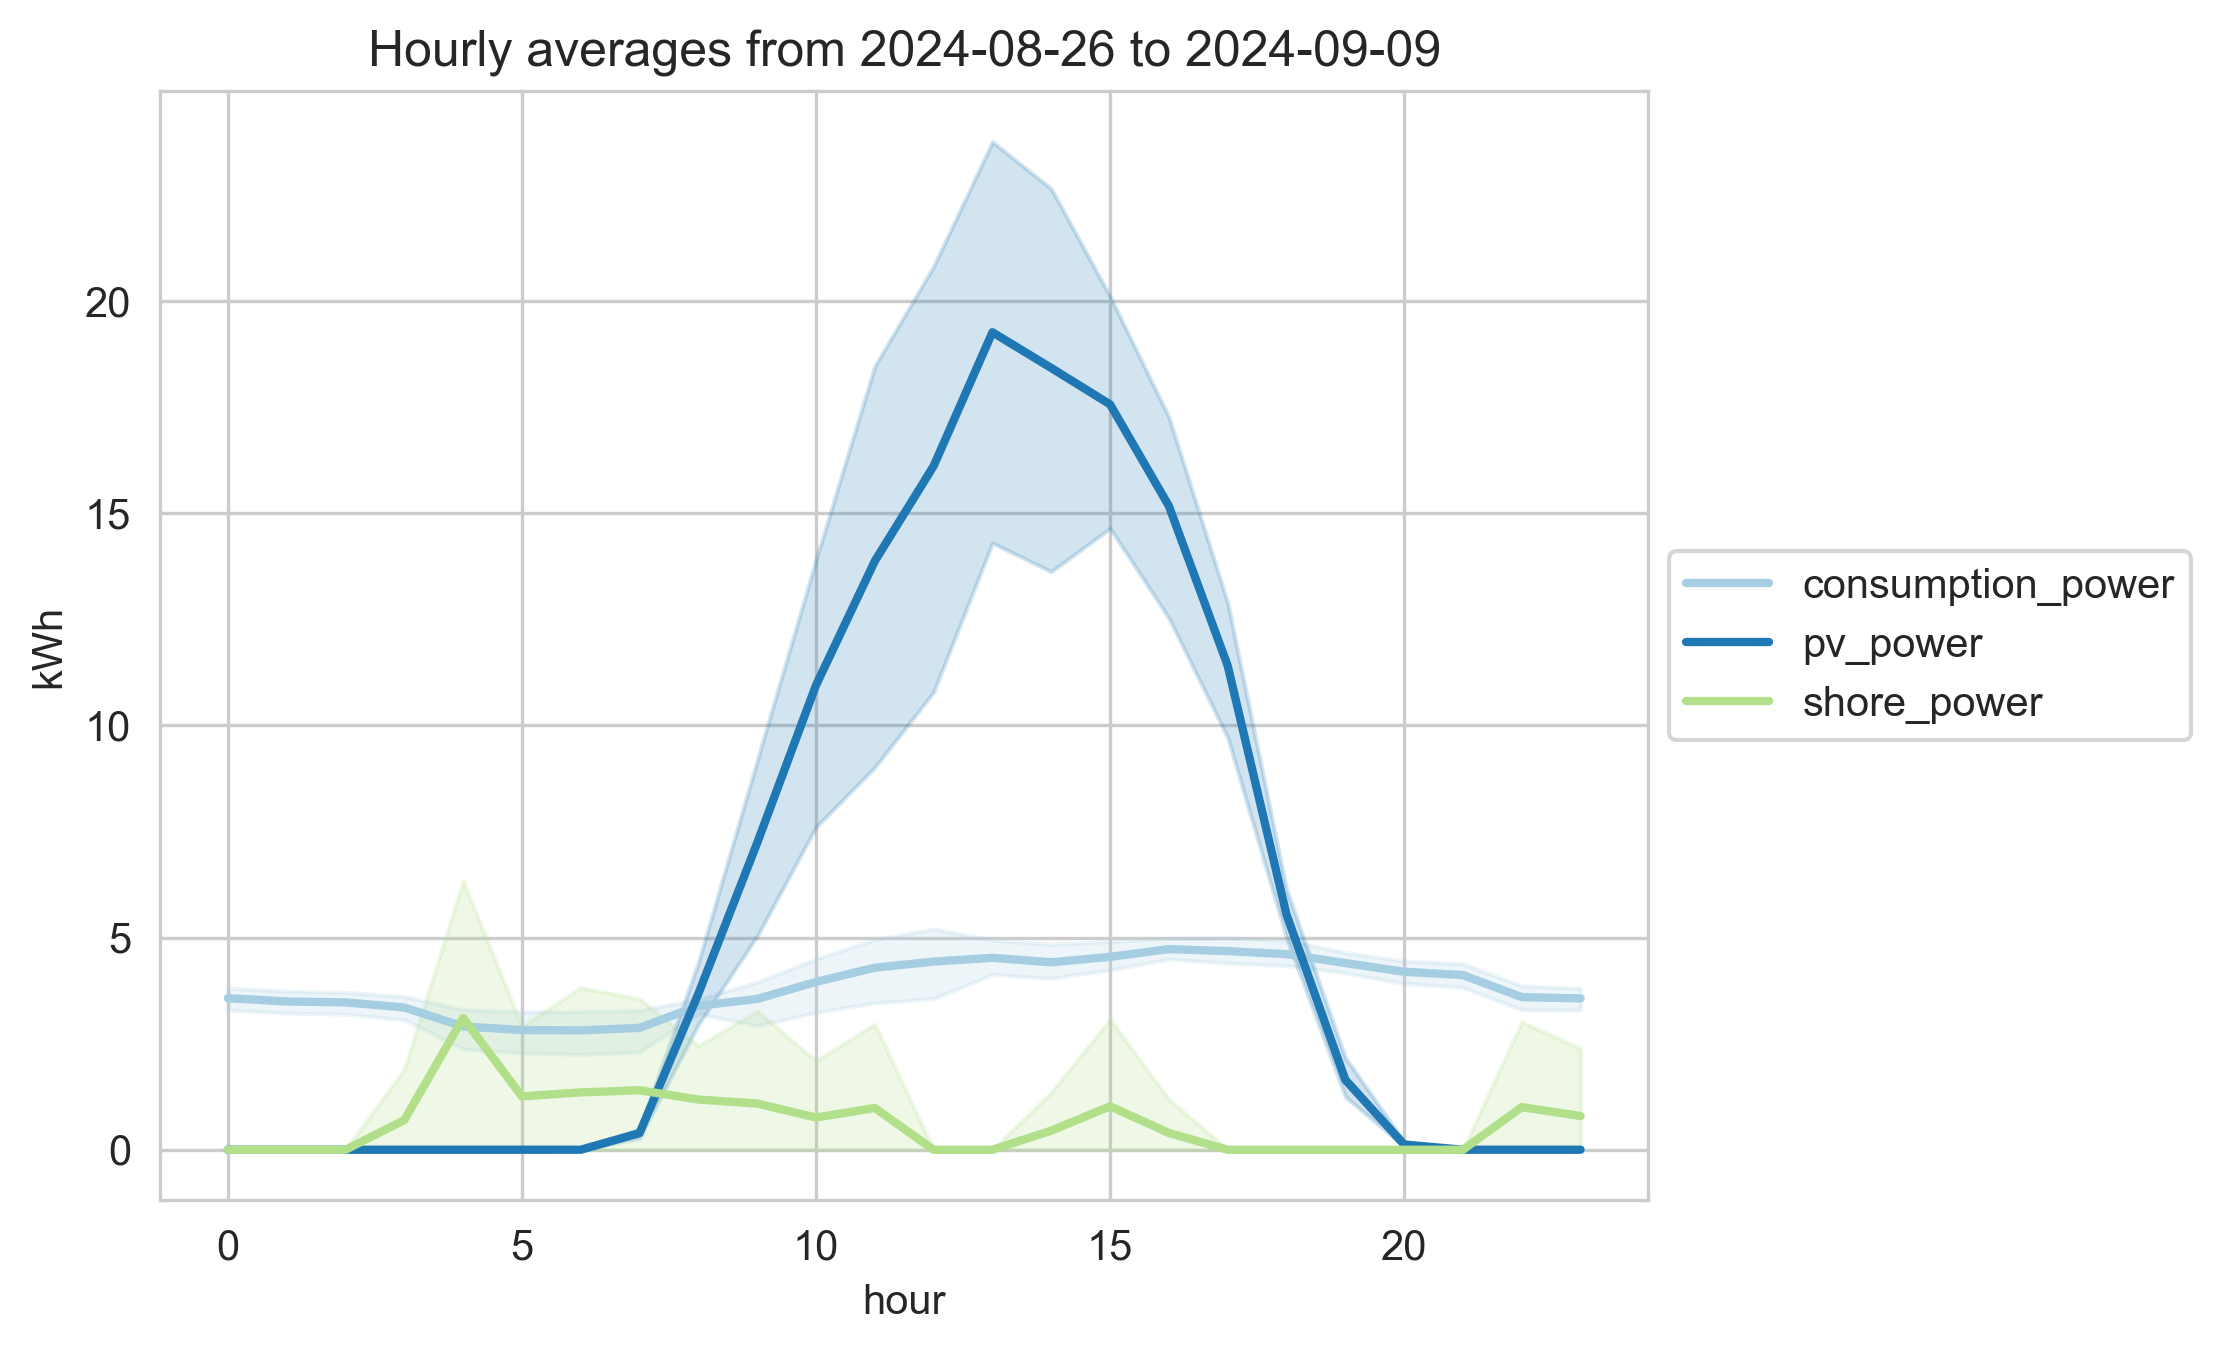

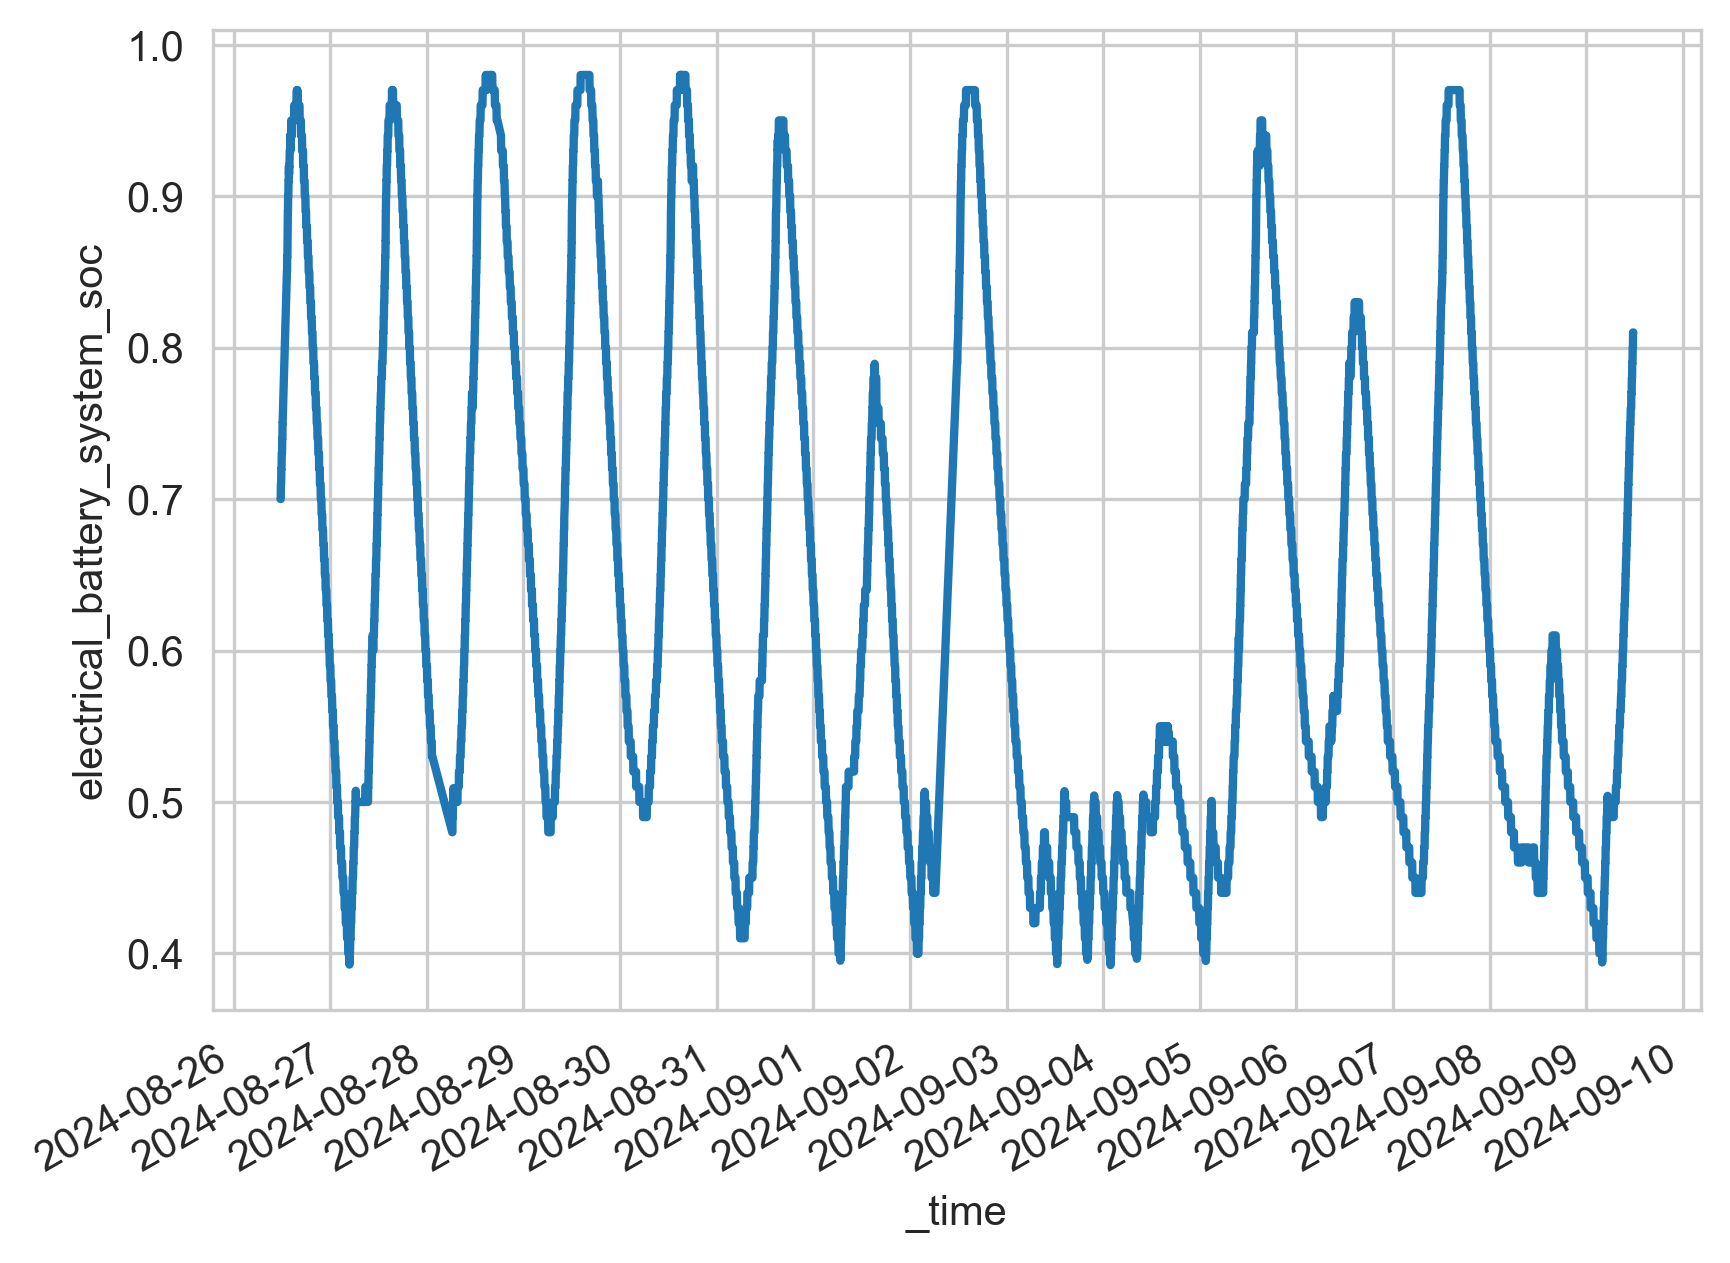

In [75]:
aggregate_electric = kwh_electric.fillna(0).T.groupby(electrical_groups_dict_inv).sum().T

plot_daily_bars(aggregate_electric, 'kWh')
plot_hourly_avg(aggregate_electric, 'kWh')

fig, ax = plt.subplots(dpi = 300)
ax = sns.lineplot(data = electric_data['electrical_battery_system_soc'], dashes = False, linewidth = 2.0, ax = ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
plt.gcf().autofmt_xdate()


In [76]:
### Breakdown of electrical energy consumption

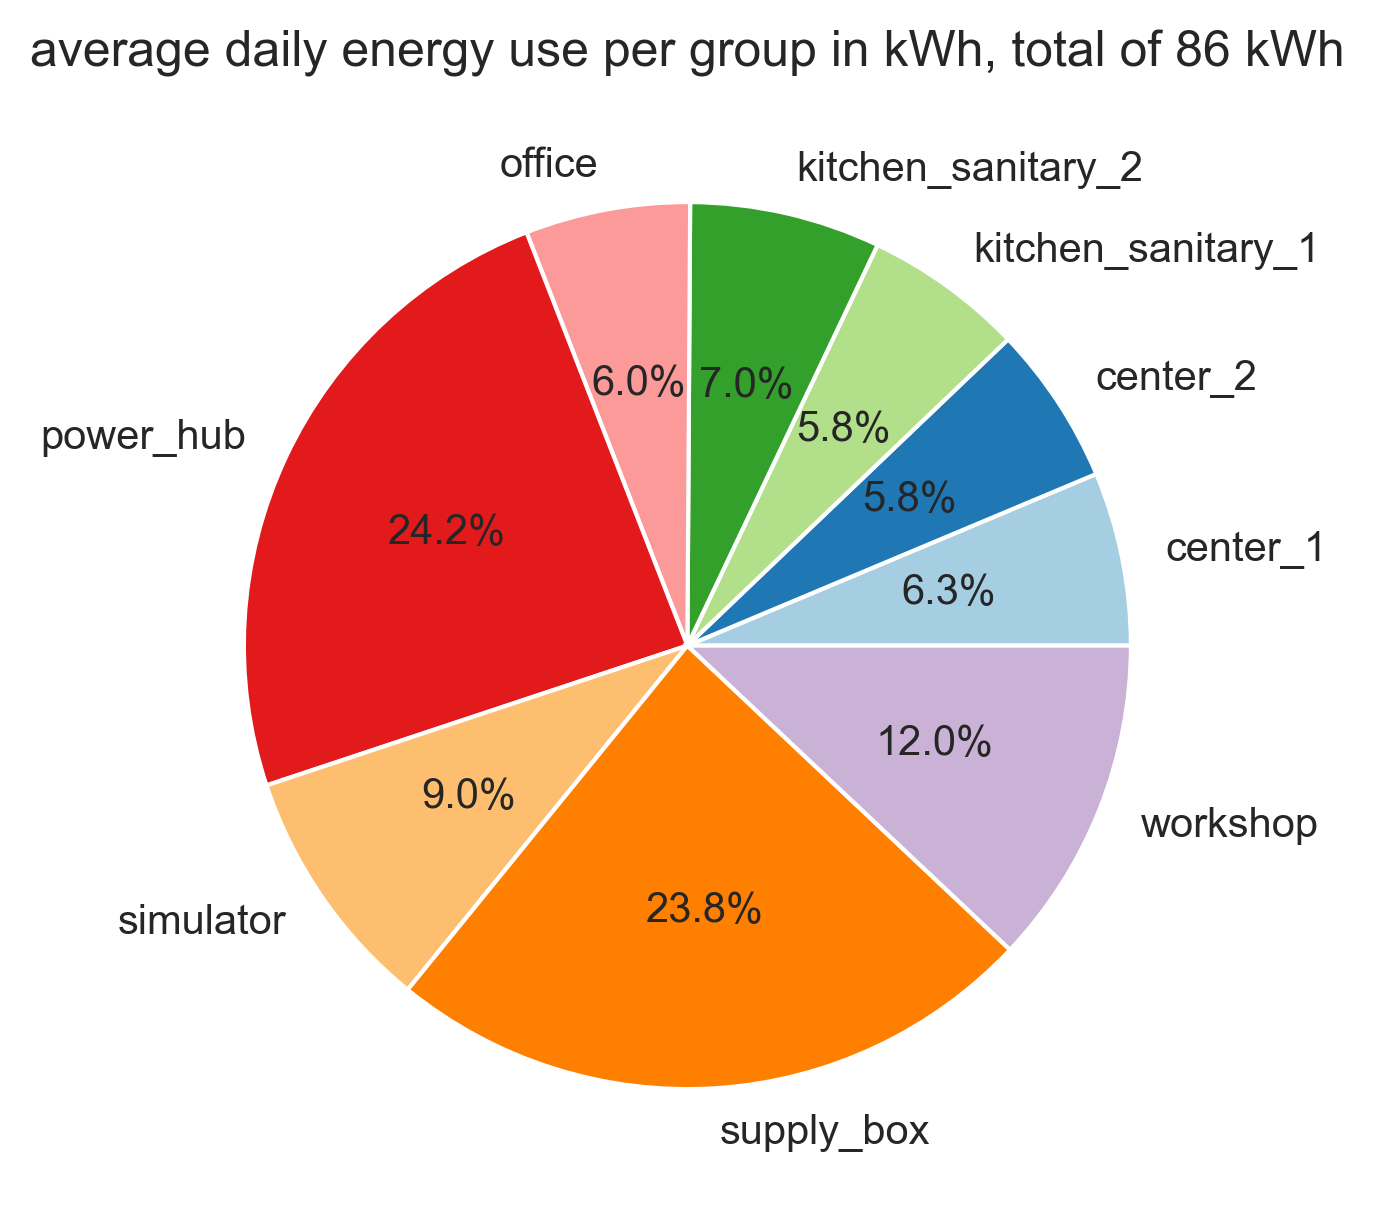

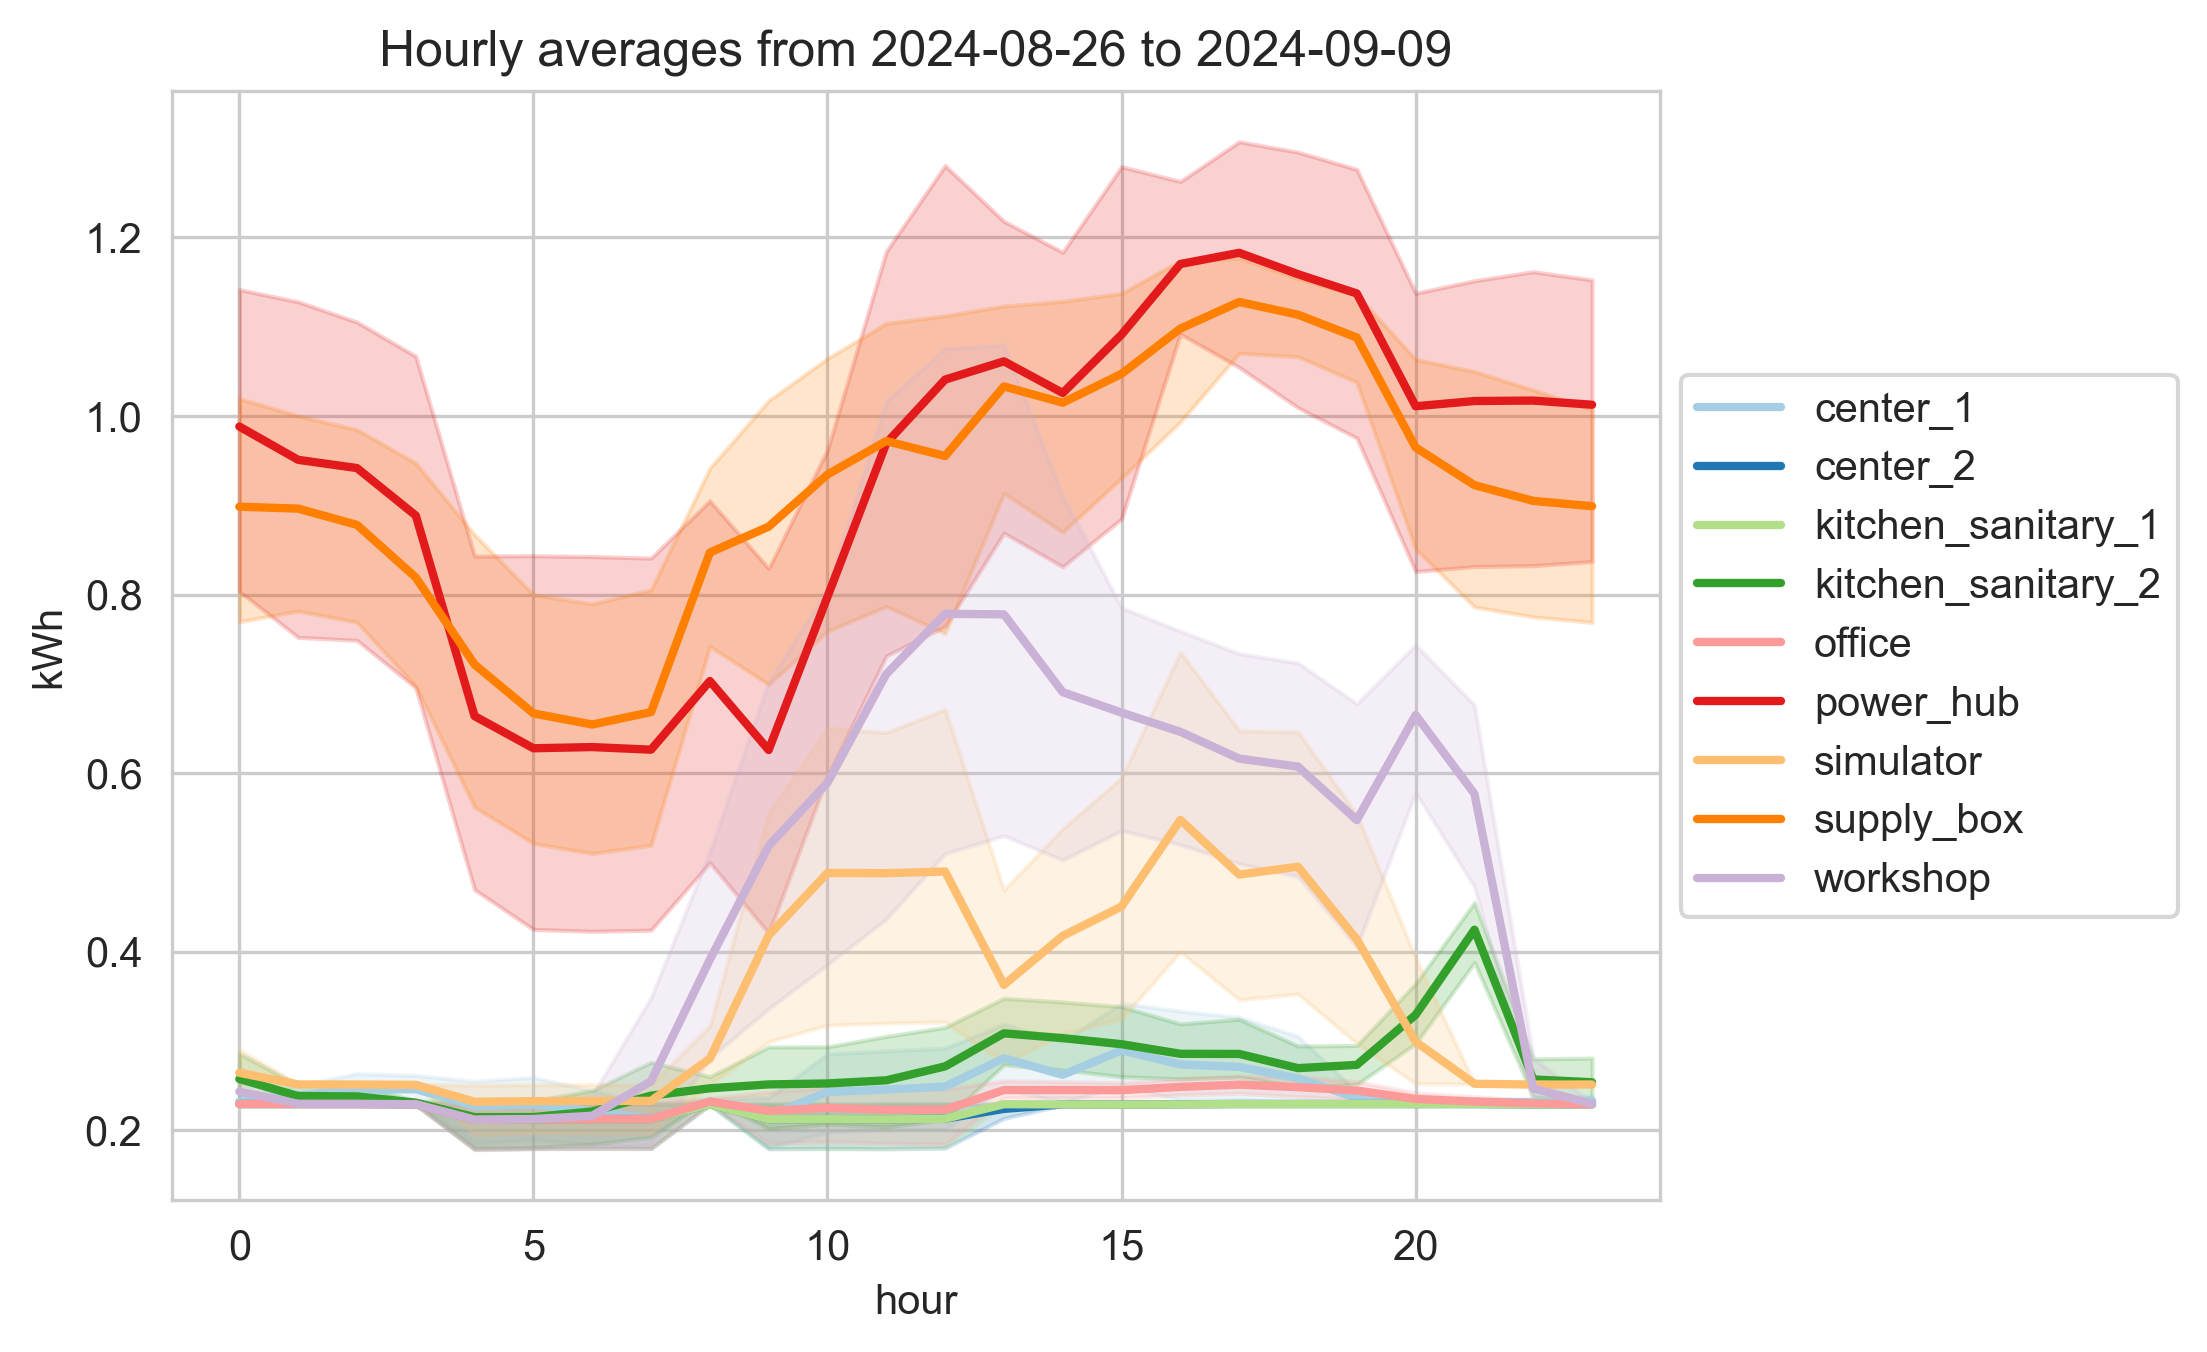

In [77]:
hourly_per_group = kwh_electric.T.groupby(electrical_consumption_groups_dict_inv).sum().T
daily_per_group = hourly_per_group.resample('d').sum()
daily_means = daily_per_group.mean()

fig, ax = plt.subplots(dpi = 300)
plt.pie(daily_means, labels =daily_means.index, autopct='%1.1f%%', colors = sns.color_palette("Paired"))
plt.title(f'average daily energy use per group in kWh, total of {daily_per_group.mean().sum():.0f} kWh')

plot_hourly_avg(hourly_per_group, 'kWh');

## Thermal 

### Aggregate thermal consumption and production

In [78]:
thermal_variables = [
    "heat_pipes_power",
    "cold_reservoir_cooling_demand",
    "yazaki_chill_power",
    "chiller_chill_power",
]

thermal_data = await get_data([{"_field": variable} for variable in thermal_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN)
thermal_data.index = thermal_data.index.tz_convert('Europe/Madrid')

kwh_thermal = (thermal_data / 1000).fillna(0).resample('h').mean()

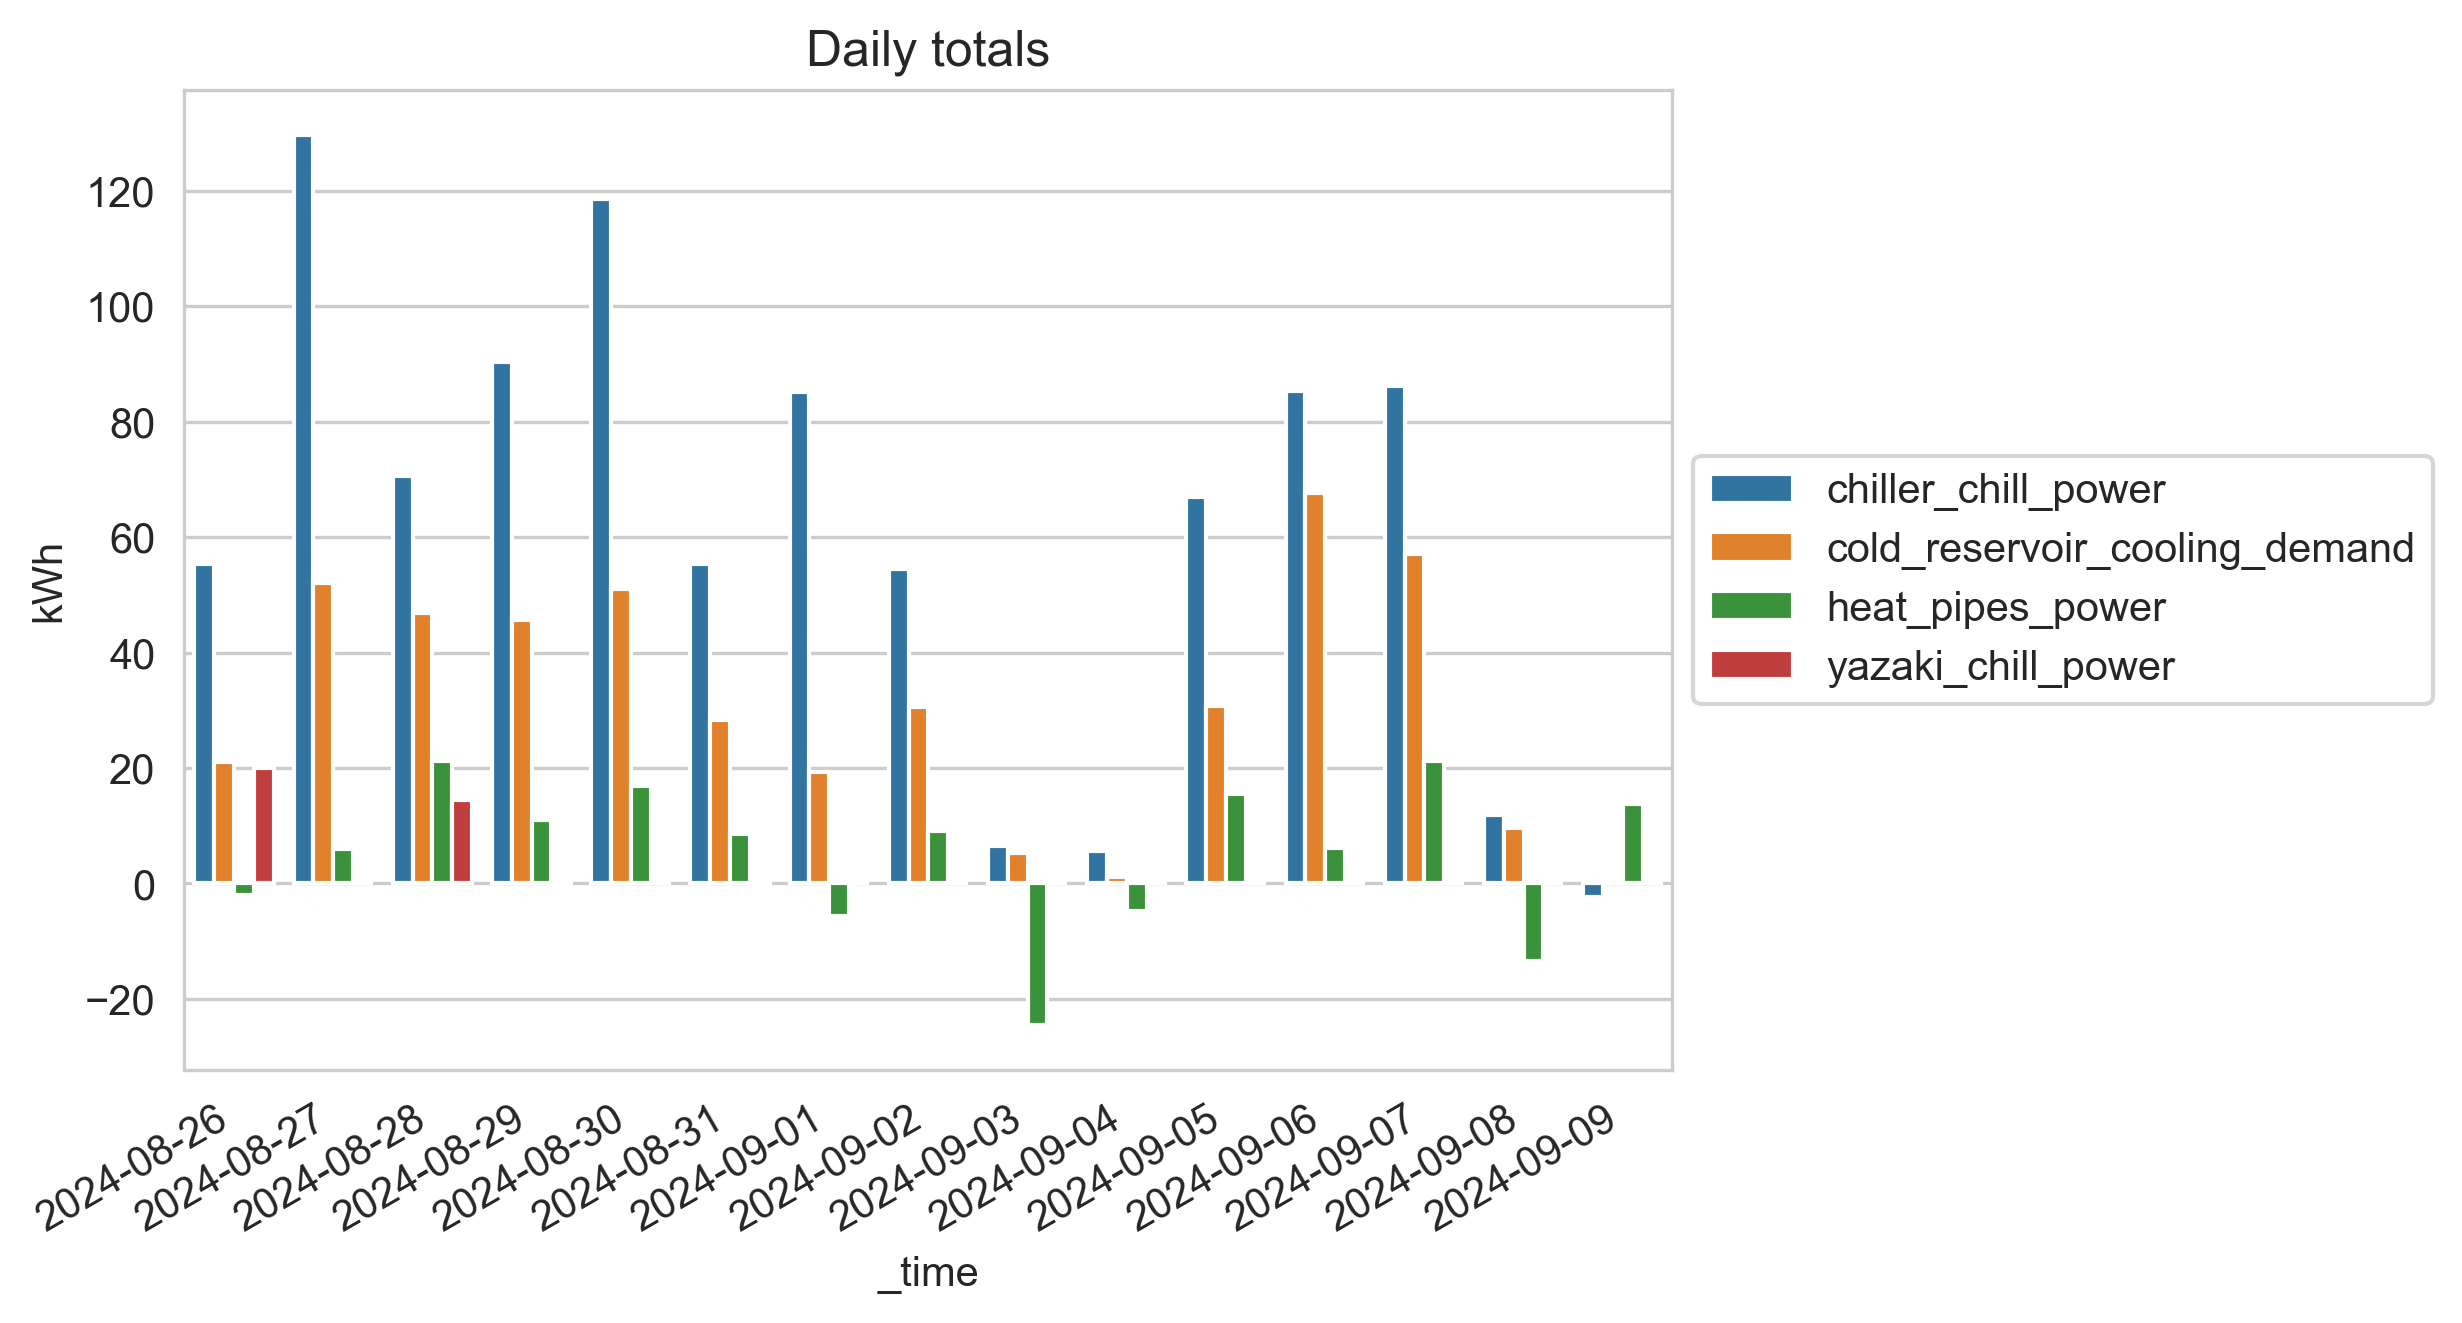

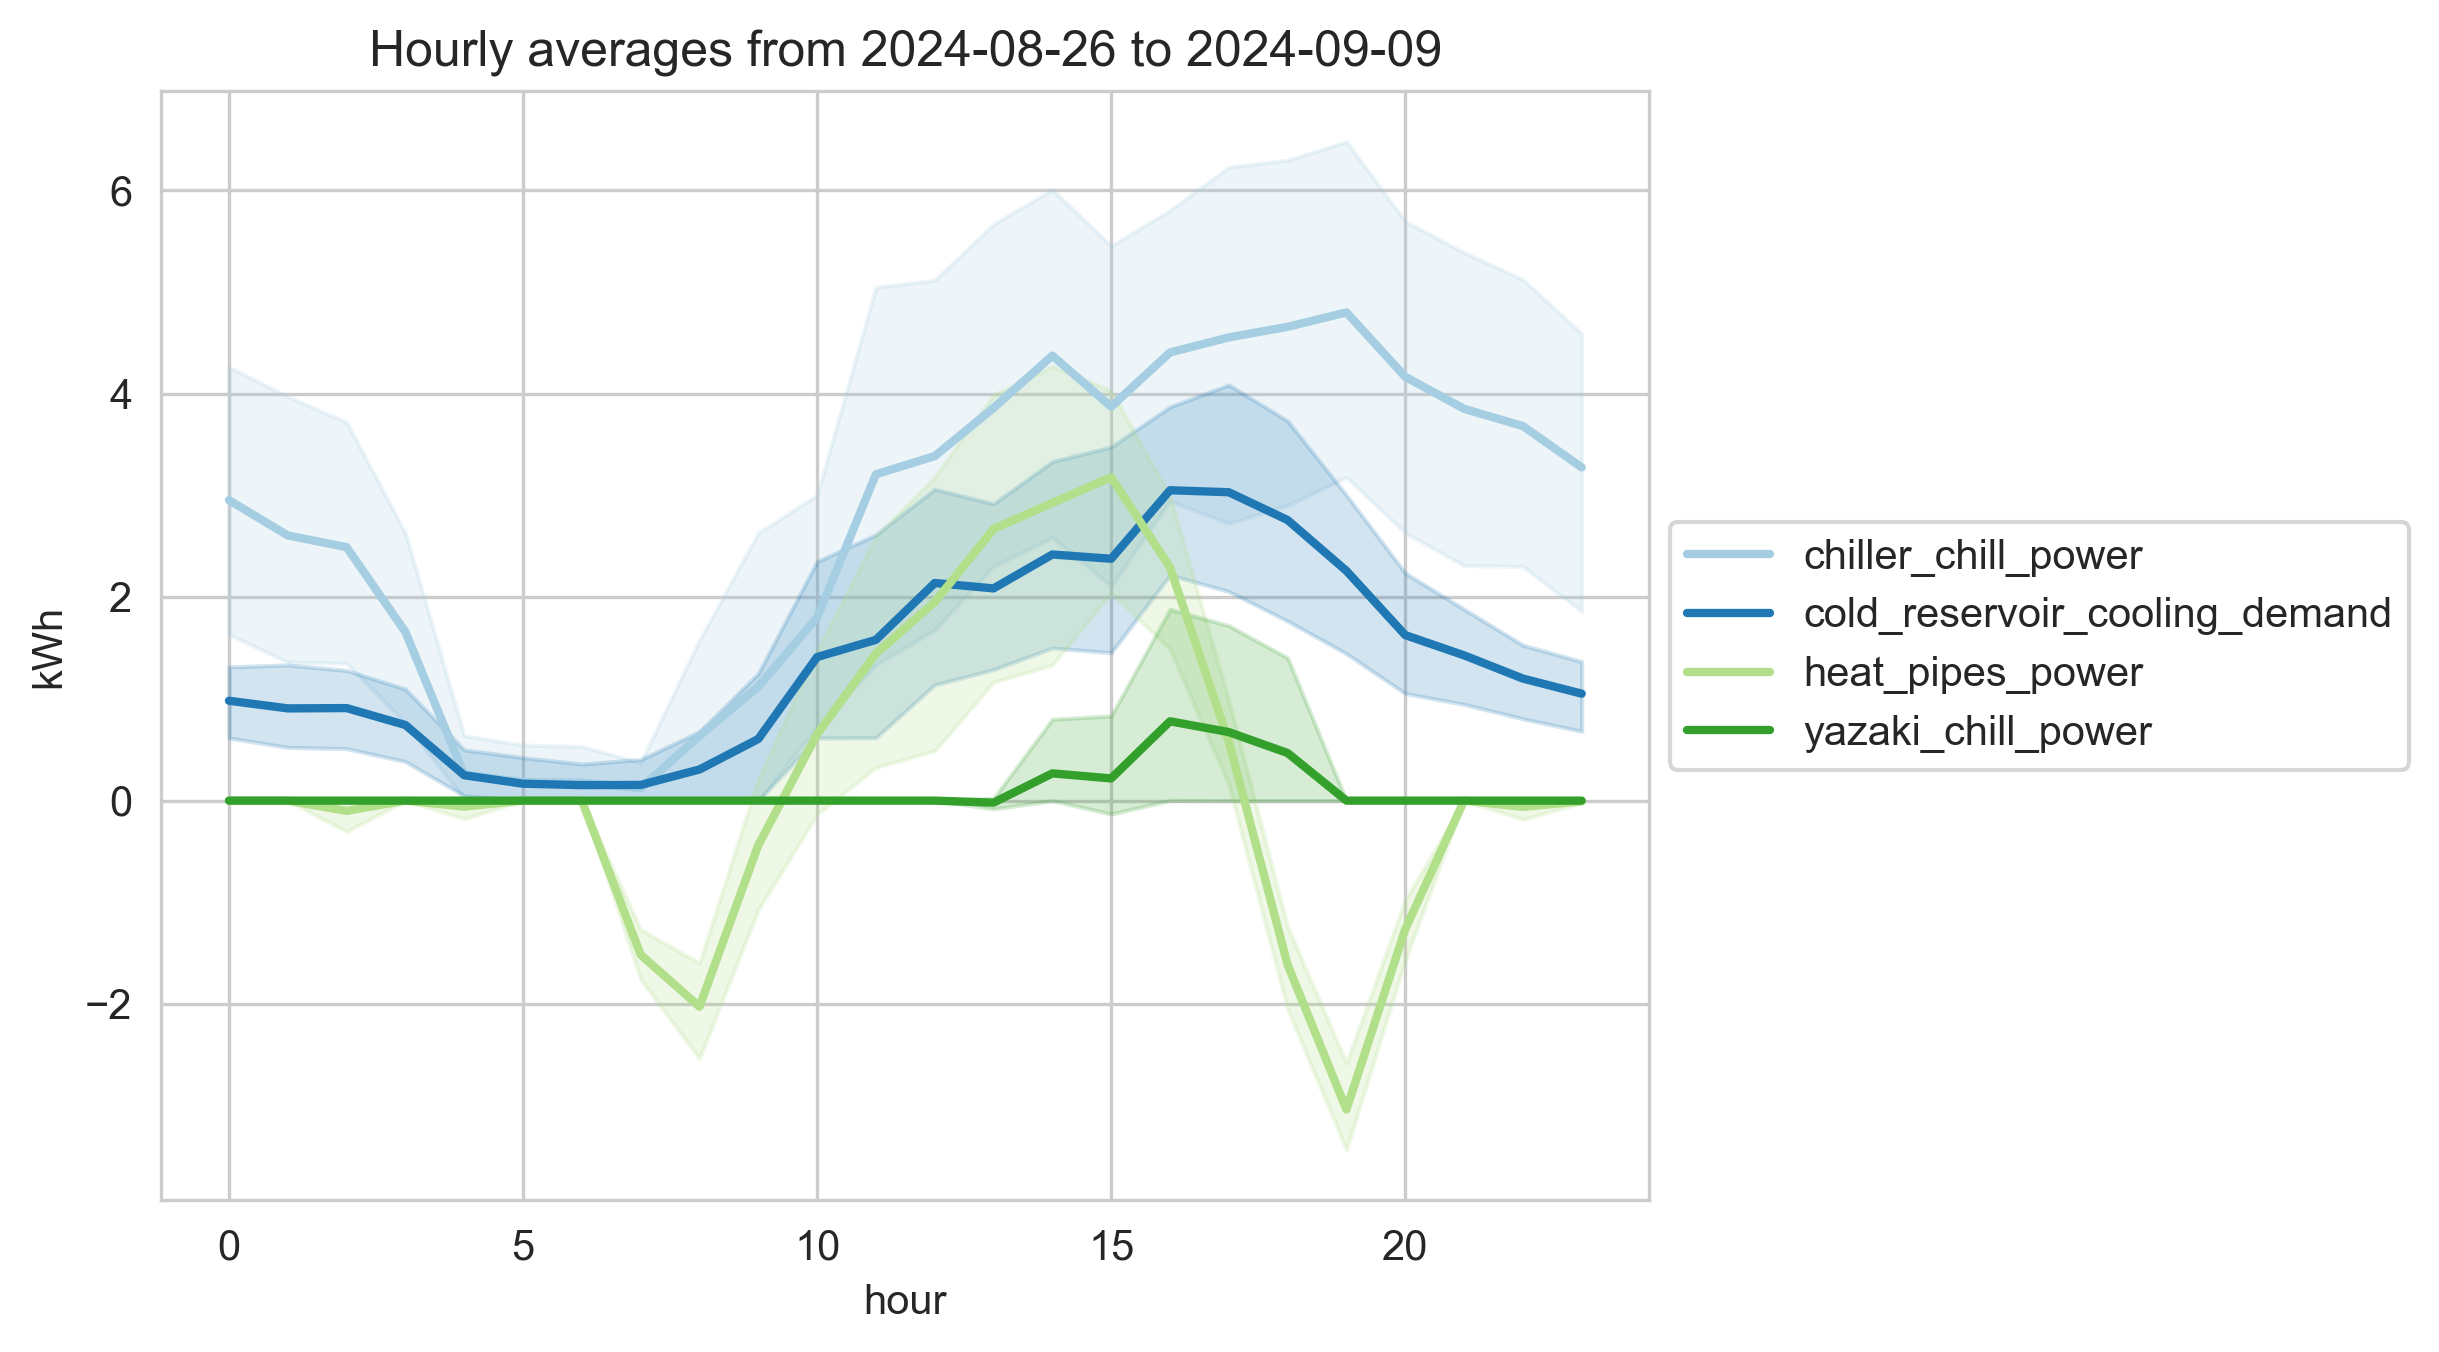

In [79]:
plot_daily_bars(kwh_thermal, 'kWh')
plot_hourly_avg(kwh_thermal, 'kWh')

## Water

### Aggregate water use and production

In [80]:
volume_variables = [
    "fresh_to_kitchen_flow_sensor_total_volume",
    "technical_to_wash_off_flow_sensor_total_volume",
    "technical_to_sanitary_flow_sensor_total_volume"
]

flow_variables = ["water_maker_production_flow"]

volumes_data = await get_data([{"_field": variable} for variable in volume_variables], (start, stop), timedelta(hours = 1), fl.WindowOperation.LAST)
volumes_data.index = volumes_data.index.tz_convert('Europe/Madrid')

flows_data = await get_data([{"_field": variable} for variable in flow_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN)
flows_data.index = flows_data.index.tz_convert('Europe/Madrid')

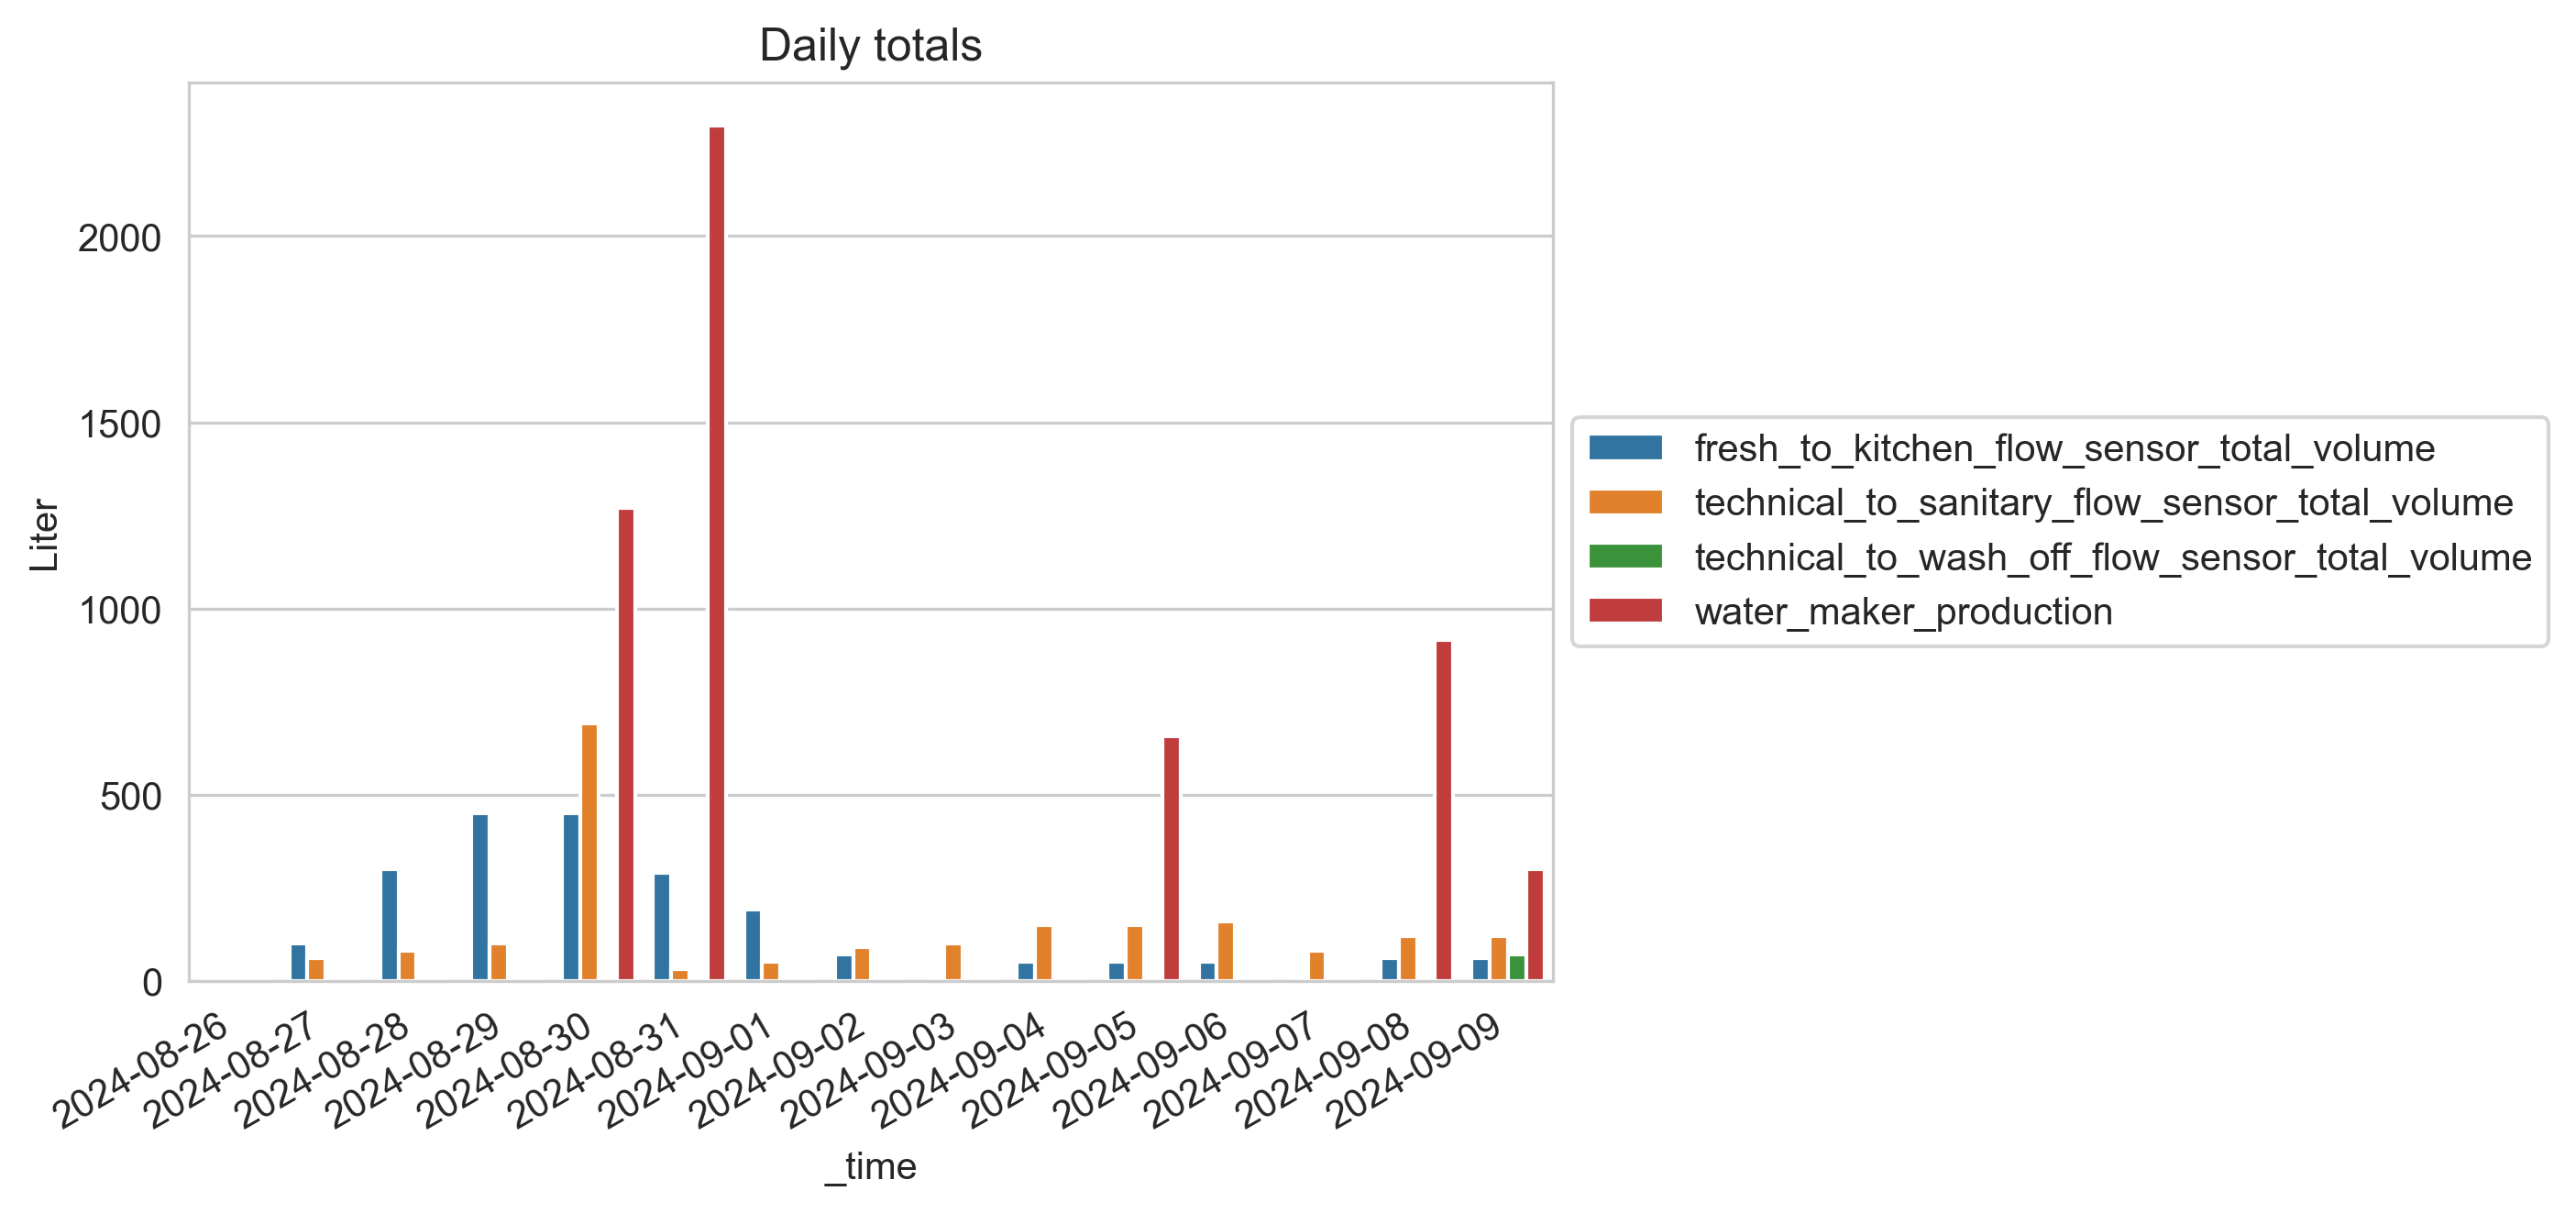

In [81]:
daily_water_maker_total = (flows_data["water_maker_production_flow"]).fillna(0).cumsum().resample('d').last() #water maker flow is in liter/minute
daily_totals = (volumes_data.resample('d').last()*1000).assign(water_maker_production = daily_water_maker_total) #volumes_data is in m3, convert to liter
daily_volumes = daily_totals.diff() 

plot_daily_bars(daily_volumes, 'Liter')

### Water tank levels

In [82]:
storage_variables = [
    "fresh_water_tank_fill_ratio",
    "technical_water_tank_fill_ratio",
    "black_water_tank_fill_ratio"
]


storage_data = await get_data([{"_field": variable} for variable in storage_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN)
storage_data.index = storage_data.index.tz_convert('Europe/Madrid')

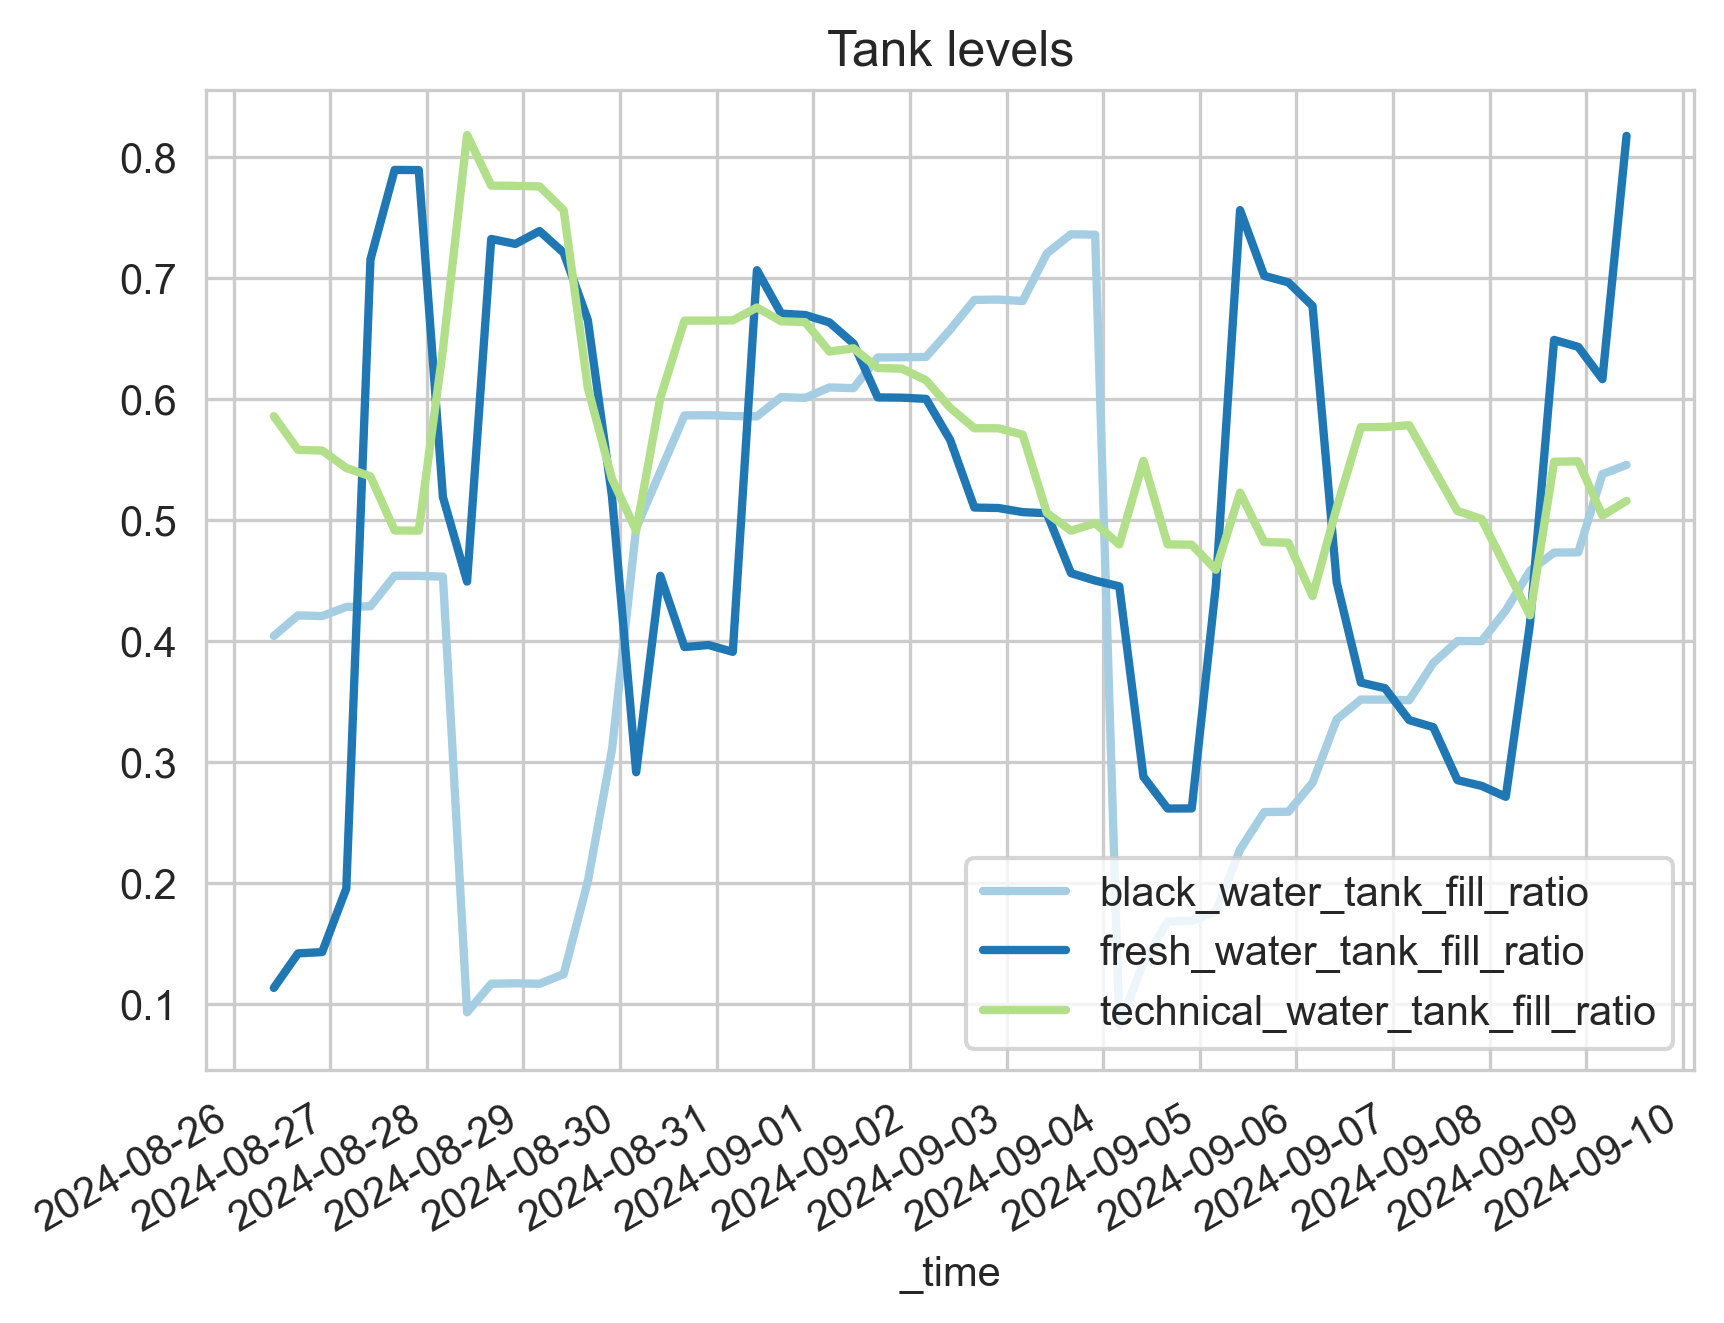

In [83]:
fig, ax = plt.subplots(dpi=300)
ax = sns.lineplot(data = storage_data.resample('6h').last(), palette = 'Paired', dashes = False, linewidth = 2.0, ax = ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
plt.gcf().autofmt_xdate()
plt.title('Tank levels');